<font size="+3">
    <b>Take-Home Final Exam</b>
</font>
<br>

# Instructions
<br>
<font size="+2">
    <ul>
        <li>Answer the following questions to the best of your ability.</li>
        <br>
        <li>All code should be able to run to receive full credit.</li>
        <br>
        <li>Document your code to help explain what you are doing in order to receive partial credit. </li>
        <br>
        <li>The final is open book, notes, and internet, <b style="color:red"><font color="red">but not collaborative. Any collaboration will result in an immediate failing for all parties involved!</font></b></li>
        <br>
        <li>Please ask (<b style="color:blue">on Slack</b>) if anything is unclear.</li>
        <br>
        <li><font color="red"><b>There are many parts of this midterm that are intentionally open-ended, or require you to look things up on your own.</b></li>
        <br>
        <li>Your effort to articulate a well-formulated solution will be considered when grading these problems, i.e. partial credit will be given.</font></li>
        <br>
    </ul>
</font>

# Imports

In [1]:
!pip install keras_tuner

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
import keras_tuner as kt
import pickle
import time

import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/My Drive/DSO_464_Spring_2024/17_Final_(Take_Home)/Data/'

# Overview of Final
<br>
<font size="+1">
  <ul>
    <li>This final will consist of two parts; the first will be related to convolutional networks and the second will be related to sequence modeling with Transformers and Hugging Face.</li>
    <br>
    <li>You will need to run some of the given code to help wrangle and process the various data sets.</li>
    <br>
    <font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
    <br>
    <font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
    <br>
  </ul>
</font>

$\square$

$\rule{800pt}{20pt}$



# Convolutional Networks

- <i>GOAL: To build a convolutional network that can classify images.</i>

<br>
<font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
<br>
<font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
<br>

**NOTE**: I have made a few changes to the provided code ot speed up the training. More spefically:
- I decresed the number of epochs from 10 to 5
- I increased the batch size from 32 to 128
Also, I have bought the colab premium plan to get a GPU as I finished the free-of-charge GPU. Nonetheless, I still struggle to train these models!

## Utils Functions

In [4]:
def get_img_data(dir_path: Path):
  data = pd.DataFrame(columns=["category", "image"])

  for category_path in dir_path.iterdir():
    category = os.path.basename(category_path)
    img_names = []

    for img_path in category_path.iterdir():
      img_name = os.path.basename(img_path)
      img_names.append(img_name)

    data_category = pd.DataFrame(columns=["category", "image"])
    data_category["image"] = img_names
    data_category["category"] = category
    data = pd.concat([data, data_category])

  return data

In [5]:
train = get_img_data(Path(data_path) / "seg_train")
test = get_img_data(Path(data_path) / "seg_test")

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 16,  23,  20],
        [ 15,  22,  19],
        [ 16,  22,  17],
        ...,
        [ 14,  22,  21],
        [ 15,  23,  22],
        [ 12,  20,  19]],

       [[ 17,  22,  20],
        [ 15,  20,  18],
        [ 15,  21,  16],
        ...,
        [ 14,  22,  21],
        [ 14,  22,  21],
        [ 20,  28,  27]],

       [[ 16,  21,  19],
        [ 14,  19,  17],
        [ 13,  19,  14],
        ...,
        [ 10,  18,  17],
        [ 17,  25,  24],
        [ 21,  29,  28]]], dtype=uint8)
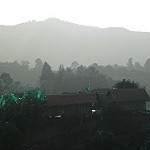

In [6]:
cv2.imread(os.path.join(data_path, 'seg_train' , "mountain" , '11871.jpg'))

In [7]:
# plotting functions, asjuted from class for new dataset

def plot_figures(figures, nrows = 1, ncols=1, figsize=(6, 6)):
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for index, title in enumerate(figures):
        img = figures[title][0]
        category = figures[title][1]
        axes.ravel()[index].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes.ravel()[index].set_title(title)
        axes.ravel()[index].set_xlabel(category)
    plt.tight_layout()


def load_image(img_name):
    try:
      category = train.loc[train["image"]==img_name, "category"].iloc[0]
      img = cv2.imread(os.path.join(data_path, "seg_train", category, img_name))
    except:
      try:
        category = test.loc[test["image"]==img_name, "category"].iloc[0]
        img = cv2.imread(os.path.join(data_path, "seg_test", category, img_name))
      except:
        raise FileNotFoundError(f"No image {img_name} found")
    return img

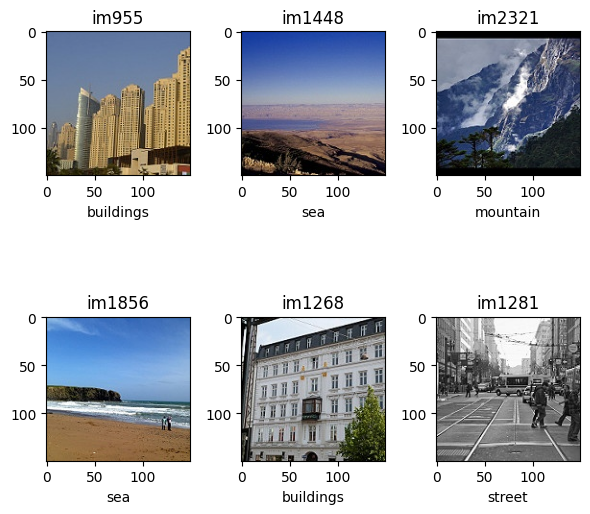

In [8]:
figures = {'im'+str(i): (load_image(row['image']), row["category"]) for i, row in train.sample(6).iterrows()}
plot_figures(figures, 2, 3)

In [9]:
def plot_history(history):
  df_history = history.history
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns, and set a suitable figure size

  ax[0].plot(df_history['loss'], label='Train Loss')
  ax[0].plot(df_history['val_loss'], label='Validation Loss')
  ax[0].set_title('Model Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  ax[1].plot(df_history['accuracy'], label='Train Accuracy')
  ax[1].plot(df_history['val_accuracy'], label='Validation Accuracy')
  ax[1].set_title('Model Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

In [10]:
def save_model(model, history, model_name):
  directory = Path("/content/drive/MyDrive/DL_final_exam")  # hard-coded but whatever
  model.save(directory / model_name)
  with open(directory / f'{model_name}.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Question 1 (12.5 points): Preparing Data for Training
<br>


- The goal of this problem is to properly prepare the image data for training and validation.

- You will use the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">ImageDataGenerator</a> method to build a pipeline that transforms the data in ways that makes the training more robust by applying data augmentation methods.

  - This includes rescaling the pixels, rotating images, shifting images, zooming images, flipping images, etc.

- <b>You need to build image generations for the training set and the validation sets.</b>

- Pass the following set of arguments to the image data generator for the TRAINING SET data:

  - rescale=1./255,
  - rotation_range=40,
  - width_shift_range=0.2,
  - height_shift_range=0.2,
  - shear_range=0.2,
  - zoom_range=0.2,
  - horizontal_flip=True,
  - fill_mode='nearest',
  - validation_split=0.1 ($\leftarrow$ this is to only use a fraction of the full data set to reduce computational time)

- In a similar fashion, create the VALIDATION SET image data generator.

  - Note, not all of the arguments should be used here, you must decide which ones should be used.

- Once you determine the validation set configuration, you should instantiate the ImageDataGenerator and run the rest of the code to generate the training and validation sets.

- <b>You might need to look up how to use this generator with the model fitting functions.</b>

$\square$

In [11]:
# Fix some hyperparameters for image configurations
IMAGE_SIZE = 150
BATCH_SIZE = 128
NUM_CLASSES = np.unique(train["category"]).size

In [12]:
# Define a path to the dataset directories
## You may need to change them depending on where you are storing the data.

train_data_path = os.path.join(data_path, 'seg_train')
validation_data_path = os.path.join(data_path, 'seg_test')

In [13]:
# Define ImageDataGenerators for training data
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1,
)

# Load images from the directories
train_generator = train_data_gen.flow_from_directory(
    train_data_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

########################################################################################################################################
########################################################################################################################################

# Define ImageDataGenerators for validation data
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255,
  validation_split=0.1
)


# Load images from the directories
validation_generator = val_data_gen.flow_from_directory(
    validation_data_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 12632 images belonging to 6 classes.
Found 298 images belonging to 6 classes.


# Question 2 (12.5 points): Create Your Own CNN Network to Classify Images
<br>

- Using your processed training and validation data from the previous question, create your own custom convolutional network.

  - It should consist of at least three convolutional blocks (consisting of a convolutional layer and a pooling layer), and at least three hidden dense layers before the final classification layer.

  - The input shape should be: <i>input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)</i>.

  - <i>You might also consider trying some regularization and other tricks methods for the dense network layers after the convolutional blocks (i.e. dropout). Be aware of training time constraints for your model.</i>

- When you compile the model, you need to pick the optimizer, choose the loss function, and keep track of the accuracy metric.

- When you fit the model, you should use the provided code below.

  - <b>You might need to look up how to use this generator with the model fitting functions.</b>

- Finally, evaluate your model on the validation data and plot the loss and metrics history.


<br>
<font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
<br>
<font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
<br>

In [14]:
# I am using a simple CNN architecture because the training is very slow
cnn_model = tf.keras.Sequential([
    # convolutions
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # fully connected
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [15]:
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [16]:
# Train the model using this training loop configuration
start_time = time.time()
cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # total train images // BATCH_SIZE
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)  # total validation images // BATCH_SIZE
)
end_time = time.time()
print(f"model trained in {(end_time-start_time)/60:.2f} minutes")

Epoch 1/5
99/99 [==============================] - 2641s 27s/step - loss: 1.6758 - accuracy: 0.3110 - val_loss: 1.2896 - val_accuracy: 0.5000
Epoch 2/5
99/99 [==============================] - 95s 961ms/step - loss: 1.3731 - accuracy: 0.4456 - val_loss: 1.0864 - val_accuracy: 0.5805
Epoch 3/5
99/99 [==============================] - 95s 955ms/step - loss: 1.2749 - accuracy: 0.4871 - val_loss: 1.1685 - val_accuracy: 0.5772
Epoch 4/5
99/99 [==============================] - 95s 955ms/step - loss: 1.1946 - accuracy: 0.5188 - val_loss: 1.0465 - val_accuracy: 0.5940
Epoch 5/5
99/99 [==============================] - 95s 954ms/step - loss: 1.1694 - accuracy: 0.5367 - val_loss: 1.1203 - val_accuracy: 0.6040
model trained in 51.12 minutes


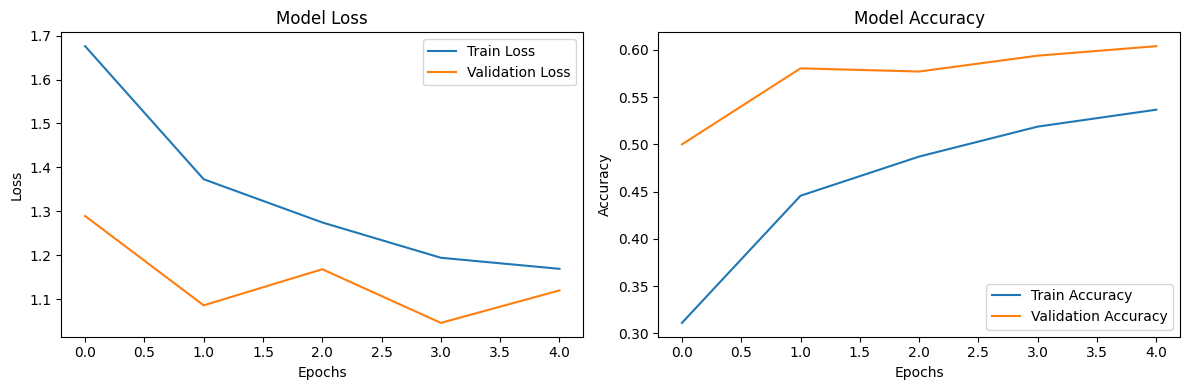

In [17]:
plot_history(cnn_history)

In [18]:
save_model(cnn_model, cnn_history, "base_cnn")

In [44]:
val_loss, val_accuracy = cnn_model.evaluate(validation_generator, steps=len(validation_generator))

# Print the results
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {(100*val_accuracy):.2f}%")

3/3 [==============================] - 1s 234ms/step - loss: 1.1203 - accuracy: 0.6040
Validation loss: 1.1203
Validation accuracy: 60.40%


# Question 3 (12.5 points): Use a <a href="https://keras.io/api/applications/resnet/#resnet50-function">ResNet-50</a> Pretrained Model to Create an Embedding Used to Classify Images
<br>

- For this problem, you should use a pretrained model, ResNet50, with weights coming from ImageNet, and you should adapt it to produce an embedding using global max pooling.

  - From this embedding, i.e. after the global max pooling layer, you should adapt the model to produce a classifier (i.e. add a dense layer with the number of units equal to the number of classes and a softmax activation function).

  - The input shape should be: <i>input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)</i>.  

  - You should not fit any of the ResNet50 model's parameters and you should use it as is.
  
  - You should, however, fit the dense layer on top that converts the embedding to a classifier.

- Finally, evaluate your model on the validation data and plot the loss and metrics history.

In [19]:
# pre-trained model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
)

for layer in base_model.layers:
	layer.trainable = False

# add classification layer
untuned_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
untuned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

untuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_3 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23600006 (90.03 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [22]:
# Train the model using this training loop configuration
start_time = time.time()
untuned_history = untuned_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # total train images // BATCH_SIZE
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)  # total validation images // BATCH_SIZE
)
end_time = time.time()
print(f"model trained in {(end_time-start_time)/60:.2f} minutes")

Epoch 1/10
99/99 [==============================] - 97s 981ms/step - loss: 1.6069 - accuracy: 0.3148 - val_loss: 1.5214 - val_accuracy: 0.3423
Epoch 2/10
99/99 [==============================] - 94s 952ms/step - loss: 1.4828 - accuracy: 0.3793 - val_loss: 1.3778 - val_accuracy: 0.4228
Epoch 3/10
99/99 [==============================] - 95s 963ms/step - loss: 1.3869 - accuracy: 0.4390 - val_loss: 1.3064 - val_accuracy: 0.4732
Epoch 4/10
99/99 [==============================] - 95s 956ms/step - loss: 1.3588 - accuracy: 0.4471 - val_loss: 1.2500 - val_accuracy: 0.4933
Epoch 5/10
99/99 [==============================] - 94s 954ms/step - loss: 1.3241 - accuracy: 0.4620 - val_loss: 1.2138 - val_accuracy: 0.5369
Epoch 6/10
99/99 [==============================] - 95s 955ms/step - loss: 1.2991 - accuracy: 0.4782 - val_loss: 1.2181 - val_accuracy: 0.5369
Epoch 7/10
99/99 [==============================] - 95s 958ms/step - loss: 1.2731 - accuracy: 0.4926 - val_loss: 1.1908 - val_accuracy: 0.5403

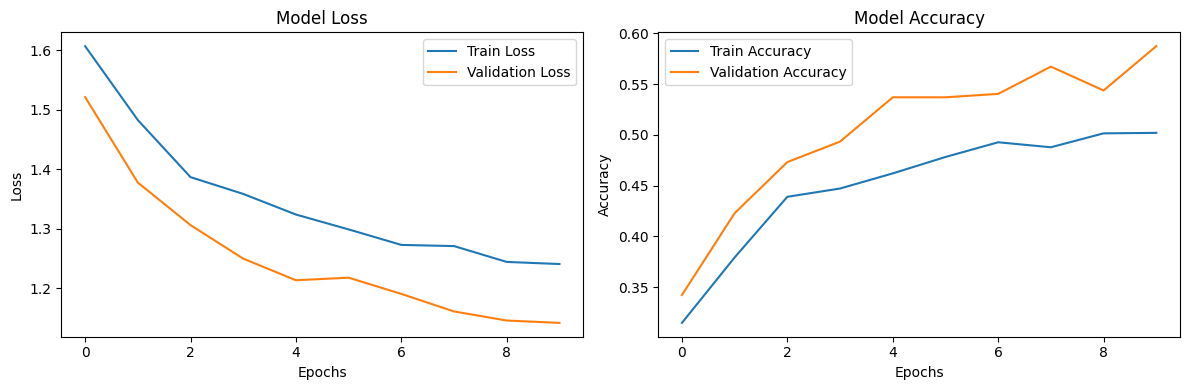

In [23]:
plot_history(untuned_history)

In [24]:
save_model(untuned_model, untuned_history, "pretrained_notuned")

In [45]:
val_loss, val_accuracy = untuned_model.evaluate(validation_generator, steps=len(validation_generator))

# Print the results
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {(100*val_accuracy):.2f}%")

3/3 [==============================] - 1s 264ms/step - loss: 1.1422 - accuracy: 0.5872
Validation loss: 1.1422
Validation accuracy: 58.72%


# Question 4 (12.5 points): Fine-tune the Pretrained Model of the Previous Question to Classify Images
<br>

- Use the same model from the previous question and unfreeze layers 35 and above so that they can be trained, which will allow the entire model to be fine-tuned to the image data.

  - For the optimizer, use Adam.

- Finally, evaluate your model on the validation data and plot the loss and metrics history.

- Write a brief description comparing how your three models performed:

  - custom CNN model trained from scratch in question 2,

  - pretrained ResNet50 model for a feature embedding in question 3,

  - fine-tuned ResNet50 model for a feature embedding in this question.


<br>
<font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
<br>
<font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
<br>

In [35]:
# pre-trained model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
)

for layer in base_model.layers:
	layer.trainable = False

# add classification layer
tuned_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

In [36]:
for layer in tuned_model.layers[35:]:
    layer.trainable = True

In [37]:
tuned_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tuned_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_5 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23600006 (90.03 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [38]:
# Train the model using this training loop configuration
start_time = time.time()
tuned_history = tuned_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # total train images // BATCH_SIZE
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)  # total validation images // BATCH_SIZE
)
end_time = time.time()
print(f"model trained in {(end_time-start_time)/60:.2f} minutes")

Epoch 1/10
99/99 [==============================] - 99s 965ms/step - loss: 1.6934 - accuracy: 0.2909 - val_loss: 1.5298 - val_accuracy: 0.3624
Epoch 2/10
99/99 [==============================] - 95s 956ms/step - loss: 1.4702 - accuracy: 0.4009 - val_loss: 1.4271 - val_accuracy: 0.4228
Epoch 3/10
99/99 [==============================] - 96s 966ms/step - loss: 1.4051 - accuracy: 0.4267 - val_loss: 1.3000 - val_accuracy: 0.4732
Epoch 4/10
99/99 [==============================] - 95s 961ms/step - loss: 1.3522 - accuracy: 0.4512 - val_loss: 1.2686 - val_accuracy: 0.5101
Epoch 5/10
99/99 [==============================] - 95s 955ms/step - loss: 1.3199 - accuracy: 0.4607 - val_loss: 1.2565 - val_accuracy: 0.5101
Epoch 6/10
99/99 [==============================] - 95s 955ms/step - loss: 1.2990 - accuracy: 0.4713 - val_loss: 1.2100 - val_accuracy: 0.5302
Epoch 7/10
99/99 [==============================] - 95s 960ms/step - loss: 1.2734 - accuracy: 0.4891 - val_loss: 1.1860 - val_accuracy: 0.5235

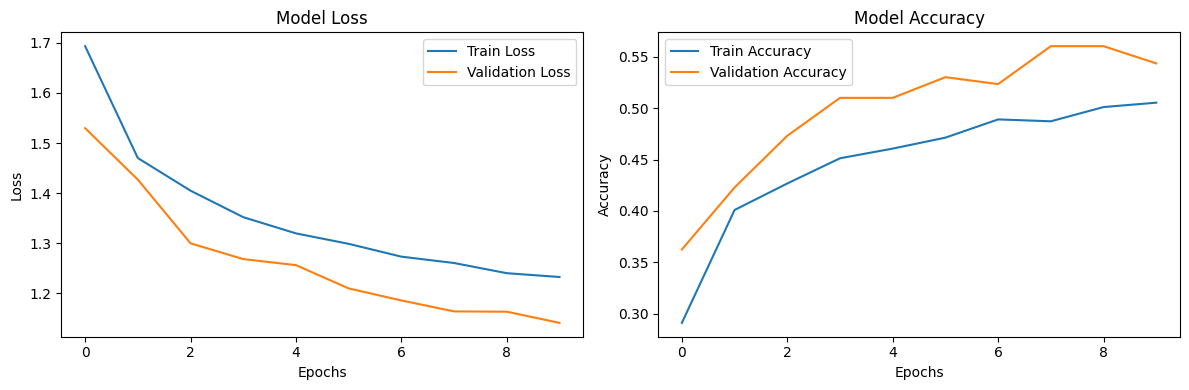

In [39]:
plot_history(tuned_history)

In [40]:
save_model(tuned_model, tuned_history, "pretrained_tuned")

In [46]:
val_loss, val_accuracy = tuned_model.evaluate(validation_generator, steps=len(validation_generator))

# Print the results
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {(100*val_accuracy):.2f}%")

3/3 [==============================] - 1s 215ms/step - loss: 1.1412 - accuracy: 0.5436
Validation loss: 1.1412
Validation accuracy: 54.36%


## Model Comparison

### Findings

- **CNN Model**
  - **Training Time:** 51.12 minutes
  - **Validation Accuracy:** 60.40%
  - Demonstrates good generalization with the highest validation accuracy among the models.
  - Indicates some overfitting as validation loss plateaus.

- **Pretrained Model (Not Fine-Tuned)**
  - **Training Time:** 15.85 minutes
  - **Validation Accuracy:** 58.72%
  - Trains faster and exhibits steady improvement, though limited by not being fine-tuned.

- **Pretrained Model (Fine-Tuned)**
  - **Training Time:** 15.89 minutes
  - **Validation Accuracy:** 54.36%
  - Performs worse on validation post fine-tuning, suggesting potential issues with the fine-tuning process such as layer selection or learning rate.

### Comparison

- The pretrained models train more quickly than the custom CNN due to leveraging pre-learned features.
- The custom CNN, while slower, provides better generalization to validation data.
- The fine-tuned model's lower performance suggests inefficiencies in the fine-tuning process, possibly due to inappropriate layer training or excessive learning rates.

### Further Improvements

- **Optimize Fine-Tuning:** The fact that the fine-tuned model performs worse than the model which is not is probably just due to inefficeint fine-tuning. Therefore, I would explore the fine-tuning process to optimize it, changing number of layers unfrozen, adjusting the learning rate, applying some regularization techniques and others.
- **Enhance CNN Architecture:** At the same time, one could keep exploring a more complex custom CNN, as this is the model performing better in this notebook. Also, the CNN was trained for 5 epochs only, which means that there is room for further improvememnts. Moreover, the architecture is not extremely complex, especially for computational reasons.

# Question 5 (12.5 points): Extend Your Analysis
<br>
<font size="+1">
    <ul>
        <font color="blue"><li>The purpose of this exercise is for you to innovate on the above questions to demonstrate your creativity in deep learning.</li>
        <br>
        <li>Treat this exercise as if you were given a take home exam from a company and you wanted to showcase your skills for a job you're hoping to land.</li>
        <br>
        <li><i>Note: Most models we build in a first passing are not very good, it takes time to build a good model from real world data. If your model doesn't perform very well, don't be discouraged, this means there is so much opportunity to improve! Keep this in mind as you do experimentation in the following question.</i></li></font>
        <br>
    </ul>
<ol>
        <li type='i'>Try different techniques, methodologies, and models to improve the image classifier, the more innovative the better.</li>
        <br>
        <li type='i'>There is no simple solution for these questions. They are intended to be vague and open ended in order for interviewers to test your critical thinking. Possible innovations you can think about include:</li>
        <ul>
            <li><i>different ways to measure classification error,</i></li>
            <br>
            <li><i>different ways to create image embeddings,</i></li>
            <br>
            <li><i>different ways to deal with class imbalances,</i></li>
            <br>
            <li><i>hyperparameter tuning,</i></li>
            <br>
            <li><i>different training loops,</i></li>
            <br>
            <li><i>ways to solve the problem of vanishing/exploding gradients or deal with overfitting through regularization,</i></li>
            <br>
            <li><i>etc.</i></li>
            <br>
        </ul>
        <li type="i">If you did any extra analysis during the above exercises, simply copy and paste the code below.</li>
        <br>        
    </ol>    
</font>

## Image Embeddings

Changes: introduced a custom attention layer + a dense layer to create more powerful embeddings.

In [98]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_filters=1):
        super(AttentionLayer, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=(1, 1), activation='sigmoid')

    def call(self, inputs):
        attention_map = self.conv1(inputs)
        return tf.keras.layers.Multiply()([inputs, attention_map])

In [99]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Make layers non-trainable
for layer in base_model.layers:
    layer.trainable = False

extended_model = tf.keras.Sequential([
    base_model,
    AttentionLayer(),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

## Gradient Problems and Overfitting

Changes: introduced dropout layer in the architecure and modified dense layer activation to swish and initialization to he normal. Introduced gradient clipping in the optimizer too and a early stopper for the training.

In [100]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Make layers non-trainable
for layer in base_model.layers[35:]:
    layer.trainable = True

extended_model = tf.keras.Sequential([
    base_model,
    AttentionLayer(),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(128, activation='swish', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [101]:
extended_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

## Hyperparameter tuning
Note: I am not going to run this. Each model training takes more than 1h, and I am out of use for the free colab GPU, so it's becoming even longer.

In [102]:
def build_model(hyper_param):
    learning_rate = hyper_param.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
    optimizer_choice = hyper_param.Choice("optimizer", values=["sgd", "adam", "rmsprop"])
    dropout_rate = hyper_param.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    activation = hyper_param.Choice("activation", values=["relu", "leaky_relu", "swish"])
    num_neurons = hyper_param.Int("num_neurons", min_value=64, max_value=512, step=64)
    pooling_type = hyper_param.Choice("pooling_type", values=["max", "avg"])
    batch_size = hyper_param.Int("batch_size", min_value=16, max_value=128, step=16)
    num_attention_filters = hyper_param.Int("num_attention_filters", min_value=1, max_value=10, step=1)
    kernel_initializer = hyper_param.Choice("kernel_initializer", values=["he_normal", "glorot_uniform", "lecun_normal"])

    if optimizer_choice == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    if pooling_type == "max":
      pooling_layer = tf.keras.layers.GlobalMaxPooling2D()
    else:
      pooling_layer = tf.keras.layers.GlobalAveragePooling2D()

    # Base model
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    for layer in base_model.layers[35:]:
        layer.trainable = True

    model = tf.keras.Sequential([
        base_model,
        AttentionLayer(num_filters=num_attention_filters),
        pooling_layer,
        tf.keras.layers.Dense(num_neurons, activation=activation, kernel_initializer=kernel_initializer),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [103]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    seed=42,
    max_trials=10,
    alpha=1e-4,
    beta=2.6
)

# tuner.search(train_generator, epochs=10, validation_data=validation_generator)
# best_params_bayes = NN_bayesian_opt_tuner.get_best_hyperparameters(num_trials=3)[0].values
# print(best_params_bayes)

Fitting the model with the above mentioned changes.

In [105]:
# Train the model using this training loop configuration
start_time = time.time()
extended_history = extended_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # total train images // BATCH_SIZE
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # total validation images // BATCH_SIZE
    callbacks=[early_stopping_callback]
)
end_time = time.time()
print(f"model trained in {(end_time-start_time)/60:.2f} minutes")

Epoch 1/10
99/99 [==============================] - 125s 976ms/step - loss: 0.8135 - accuracy: 0.7496 - val_loss: 1.7925 - val_accuracy: 0.1711
Epoch 2/10
99/99 [==============================] - 96s 968ms/step - loss: 0.4474 - accuracy: 0.8478 - val_loss: 1.8155 - val_accuracy: 0.1711
Epoch 3/10
99/99 [==============================] - 96s 967ms/step - loss: 0.3801 - accuracy: 0.8699 - val_loss: 1.7953 - val_accuracy: 0.1745
Epoch 4/10
99/99 [==============================] - 95s 961ms/step - loss: 0.3574 - accuracy: 0.8768 - val_loss: 2.2619 - val_accuracy: 0.1946
Epoch 5/10
99/99 [==============================] - 96s 967ms/step - loss: 0.3330 - accuracy: 0.8836 - val_loss: 1.6302 - val_accuracy: 0.3121
Epoch 6/10
99/99 [==============================] - 95s 961ms/step - loss: 0.3146 - accuracy: 0.8921 - val_loss: 1.7605 - val_accuracy: 0.4295
Epoch 7/10
99/99 [==============================] - 95s 957ms/step - loss: 0.3044 - accuracy: 0.8976 - val_loss: 1.1350 - val_accuracy: 0.600

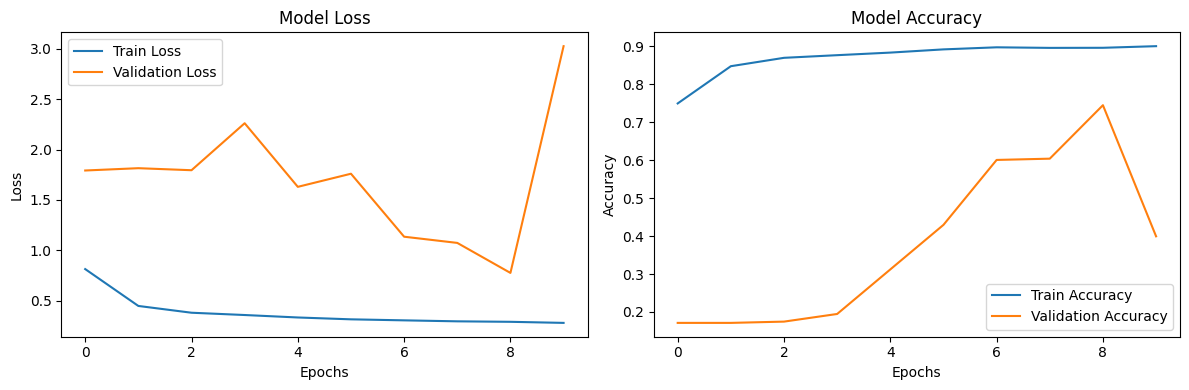

In [106]:
plot_history(extended_history)

In [107]:
save_model(extended_model, extended_history, "pretrained_extended")

In [108]:
val_loss, val_accuracy = extended_model.evaluate(validation_generator, steps=len(validation_generator))

# Print the results
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {(100*val_accuracy):.2f}%")

3/3 [==============================] - 1s 224ms/step - loss: 3.0272 - accuracy: 0.3993
Validation loss: 3.0272
Validation accuracy: 39.93%


The model seemed to perform way better than the other ones. Unfortunately, in the last epoch something went wrong. We might be overfitting, as the validation loss is increasing while the train loss is decreasing. Or it might have been some wrong steps in the optimization process. Overall, I would continue exploring this model (and also train it for more epochs) and for inference I would use this model at the epoch=9.

$\rule{800pt}{20pt}$

$\rule{800pt}{20pt}$

# Transformer Networks

- This exercise will be centered around <b>text classification</b> for sentiment analysis.

  - You will need to use Hugging Face's transformers library to access pre-trained models.

  - We will use the <i>"emotion"</i> dataset from Huggingface and classify tweets based on emotion.

- <b>There may be some things you need to look-up on your own.</b>

---
---

## Loading and Analyzing Text and Label Data

- Run the following code to install the <b>datasets</b> package from Hugging Face, and then import the <b>emotion</b> dataset.

  - You can see the dataset is stored in a dictionary consisting of three parts each consisting of text and labels:

    - training sets,

    - validation sets, and

    - testing sets

- Continue to run the code that will convert integer labels to strings.

- Additional cells will show you the distribution of labels and the distribution of words in a Tweet for a given label.

---
---

In [51]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [52]:
import datasets

emotions = datasets.load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [53]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [54]:
train_ds = emotions["train"]

In [55]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [56]:
# Data analysis
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [57]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


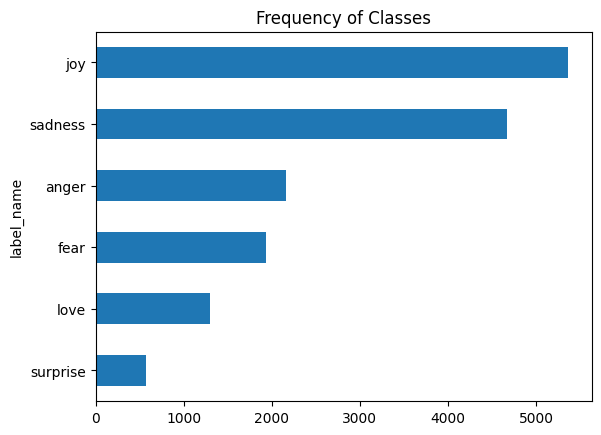

In [58]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

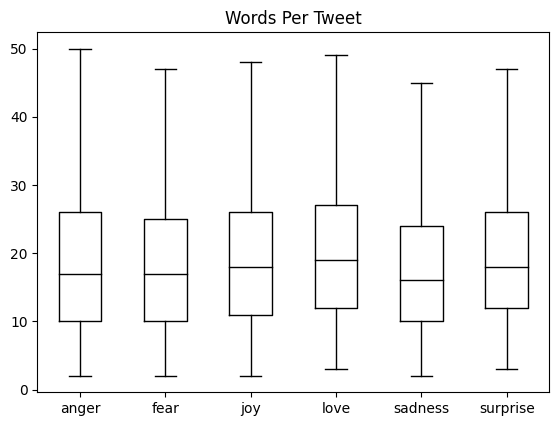

In [59]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [60]:
emotions.reset_format()

# Question 6 (12.5 points): Tokenizing Text Data

<br>

- The first step in converting our text data into machine learnable format is tokenization.

- You need to tokenize the text to convert separate the text and give it numerical values.

  - Use the Transformers AutoTokenizer method to create a tokenizer from the pre-trained BERT-based model <a href="https://huggingface.co/distilbert/distilbert-base-uncased">distilbert-base-uncased</a>.

  - Save your tokenizer in a variable named <b>tokenizer</b>, otherwise the given function will not run.

- To apply the tokenization, run the following code applied to your tokenizer.

- Also, run the code that creates a TensorFlow training, validation, and testing dataset from the tokenized data.


In [61]:
import transformers

In [62]:
## Put your tokenizer code here ##
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [63]:
## Then run the following cells ##
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [64]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [65]:
batch_size = 64

tokenizer_columns = tokenizer.model_input_names

train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)

val_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

test_dataset = emotions_encoded["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


# Question 7 (12.5 points): Model Loading, Compiling, and Fine-tuning
<br>

- Now, you should import the pre-trained model (rather than just the tokenizer) using the TFAutoModel method (hint: you need to use the AutoModel method for the right task).

  - Again, you will be using the BERT-based model <a href="https://huggingface.co/distilbert/distilbert-base-uncased">distilbert-base-uncased</a>.

  - Be sure to also specify the number of labels you need for this classification task.

---
---

- Next, you should compile the model using these parameters.

  - Optimizer: "adam"
  - Loss Function - Choose one of Binary or Sparse Categorical. (Only one is correct for this problem)
  - Metrics - Choose the accuracy based on the loss function you choose.

---
---

- Finally, fine tune the model by calling <i>.fit()</i> on top of it and use only 2 epochs (this can take a very long time to run if you are not on GPU).

  - The validation dataset should be used in the training loop.


<br>
<font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
<br>
<font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
<br>

In [66]:
NUM_LABELS = len(np.unique(df["label_name"]))

In [67]:
model = transformers.TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [68]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Fine-tune the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Epoch 1/2


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
250/250 [==============================] - 88s 174ms/step - loss: 1.5916 - accuracy: 0.3254 - val_loss: 1.5914 - val_accuracy: 0.3520
Epoch 2/2
250/250 [==============================] - 36s 143ms/step - loss: 1.5903 - accuracy: 0.3239 - val_loss: 1.5851 - val_accuracy: 0.3520


# Question 8 (12.5 points): Model Evaluation and Further Exploration
<br>

- Evaluate your model on the test data.

- Implement one method (you can use GPT for this, and it can be as creative or not as you like) that leads to an improvement in the evaluation of the test data.


<br>
<font color="red"><li><b>IF YOUR CODE IS TAKING A LONG TIME TO RUN, BE SURE YOUR RUNTIME TYPE IS USING THE <u>GPU</u>!</b></li>
<br>
<font color="red"><li><b>In the event that any of your code does not run, you may just leave your code for partial credit.</b></li>
<br>

In [71]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print(f"Test Accuracy: {100*(test_accuracy):.2f}%")

32/32 [==============================] - 1s 41ms/step - loss: 1.5626 - accuracy: 0.3475
Test Loss: 1.5626277923583984
Test Accuracy: 34.75%



Data augmentation through synonym replacement helps increase a model's accuracy by expanding the training dataset and introducing linguistic variations. This method trains the model on both original and modified texts, enhancing its ability to generalize and handle varied inputs effectively. Consequently, the model becomes better at recognizing and classifying emotions in texts, which is crucial for improving its performance on unseen data.

In [73]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.0 MB/s eta 0:00:00


In [79]:
import nlpaug.augmenter.word as naw

In [96]:
def augment_data(texts, augmenter, num_augments=1):
    augmented_texts = []
    for text in texts:
        augmented = augmenter.augment(text, n=num_augments)
        augmented_texts.extend(augmented if isinstance(augmented, list) else [augmented])
    return augmented_texts

# Create an augmenter instance and apply augmentation
augmenter = naw.SynonymAug(aug_p=0.1)
augmented_texts = augment_data(emotions["train"]["text"], augmenter)

# Combine original and augmented texts and labels
all_texts = emotions["train"]["text"] + augmented_texts
all_labels = np.concatenate((emotions["train"]["label"], emotions["train"]["label"]))
combined_encoded = tokenizer(all_texts, padding=True, truncation=True)

def create_tf_dataset(features, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(len(labels)).batch(batch_size)
    return dataset

# prepare data
train_dataset = create_tf_dataset(combined_encoded, all_labels, 64)
val_encoded = tokenizer(emotions["validation"]["text"], padding=True, truncation=True)
val_dataset = create_tf_dataset(val_encoded, emotions["validation"]["label"], 64)


model = transformers.TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the 

Epoch 1/2
500/500 [==============================] - 103s 153ms/step - loss: 1.5871 - accuracy: 0.3240 - val_loss: 1.5796 - val_accuracy: 0.3520
Epoch 2/2
500/500 [==============================] - 69s 138ms/step - loss: 1.5814 - accuracy: 0.3301 - val_loss: 1.5864 - val_accuracy: 0.3520


In [97]:
# test_encoded = tokenizer(emotions["test"]["text"], padding=True, truncation=True)
# test_dataset = create_tf_dataset(test_encoded, emotions["test"]["label"], 64)

val_loss, val_accuracy = model.evaluate(val_dataset)
print("Test Loss:", val_loss)
print(f"Test Accuracy: {100*(val_accuracy):.2f}%")

32/32 [==============================] - 1s 40ms/step - loss: 1.5864 - accuracy: 0.3520
Test Loss: 1.5864291191101074
Test Accuracy: 35.20%


Apparently, data augmentation through synonims did not help, as the accuracy increased just by little (less than 1%).
Now, I will work on different hyperparameters, especially regarding the learning rate. Adjusting it using a scheduler will help control how model weights are updated, avoiding too fast or too slow convergence. I will combine this with weight decay with the hope of improving model generalization.

In [91]:
model = transformers.TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Initialize optimizer with learning rate scheduler
num_train_steps = len(train_dataset) * 2  # Assuming 2 epochs
optimizer, schedule = transformers.create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
500/500 [==============================] - 101s 147ms/step - loss: 0.3998 - accuracy: 0.8595 - val_loss: 0.1355 - val_accuracy: 0.9410
Epoch 2/2
500/500 [==============================] - 69s 138ms/step - loss: 0.1323 - accuracy: 0.9470 - val_loss: 0.1268 - val_accuracy: 0.9360


In [95]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print("Test Loss:", val_loss)
print(f"Test Accuracy: {100*(val_accuracy):.2f}%")

32/32 [==============================] - 1s 41ms/step - loss: 0.1268 - accuracy: 0.9360
Test Loss: 0.12679149210453033
Test Accuracy: 93.60%


Wow that is a very good accuracy! Incredible how the model performance increase just with some few tweaks! Time is over for the final so I will stop exploring other solutions!

$\rule{800pt}{20pt}$

$\rule{800pt}{20pt}$

# TurnItIn
<br>
<font size="+1">
    <ul>
        <li>Submit this to TurnItIn on Blackboard -> Assignments.</li>
        <br>
        <li><b>Please double check your submission on TurnItIn (perhaps log out and log in to make sure your solution is loaded as you want it) as it will be very difficult to make any grading adjustments after submission.</b></li>
        <br>
        <li>Be sure to save your work on your computer in case anything goes wrong!</li>
        <br>
    </ul>
</font>

$\rule{800pt}{20pt}$